# 0_Generalisation.ipynb — Extensive Description

## Purpose

This notebook is focused on exploring and implementing the process of merging subgenres into main genres within the FMA (Free Music Archive) dataset. The goal is to increase the number of usable labeled tracks by generalizing ambiguous or missing genre labels using subgenre information.

## Workflow and Major Steps

1. Notebook Summary and Objective

    The notebook opens with a markdown summary:

        “This notebook is the exploration of mashing subgenre into genres in FMA dataset to gather more data.”

    It sets the context that the main objective is to increase dataset size for downstream machine learning by re-assigning tracks from subgenres to the main genres.

2. Imports and Utilities

    Common data science libraries (such as matplotlib) and custom utilities from the repo (utils.import_data_science) are imported to provide a consistent environment for data loading, manipulation, and visualization.

3. Dataset Inspection

    The notebook demonstrates directory listing within the metadata directory to explore available files such as tracks.csv, genres.csv, raw_genres.csv, and other relevant CSV and parquet files.
    This phase ensures that the necessary metadata is present for further processing.

4. Subgenre Analysis

    The notebook contains code and output cells that investigate the mapping and quantity of subgenres per main genre.
    For example, it may print or plot “Subgenres amount for each genre,” helping the user understand the granularity and redundancy in genre labeling.

5. Generalization Logic

    The code proceeds to examine tracks with missing or ambiguous main genre labels.
    It uses information from subgenres (possibly parsing raw_genres.csv and tracks.csv) to infer and assign a main genre where possible.
    Functions from utils are likely used to facilitate this mapping and transformation.

6. Data Validation and Visualization

    The notebook likely displays statistics before and after the generalization process:
        Number of tracks with missing genres
        Number of tracks successfully relabeled after generalization
        Genre distribution plots before and after the operation
    Visualization with matplotlib is used for clear comparison and reporting.

7. Saving Outputs

    After successful generalization, the notebook saves the cleaned and enriched dataset as CSV or Parquet files (e.g., tracks_clean.csv, tracks_clean_25-05-28-1908.parquet).
    These outputs are used in subsequent steps of the pipeline (such as audio extraction and feature engineering).

8. Comments and Reporting

    Markdown and code comments explain the reasoning and impact of each step, such as why certain genres are grouped, or what the resulting class balance is.
    There is a focus on transparency and reproducibility, allowing others to understand and repeat the generalization process.

Key Features

    Exploratory and Reproducible: The notebook is written for iterative data analysis, allowing for step-by-step inspection and adjustment.
    Visualization: Uses matplotlib for bar charts and other plots to show genre distributions and the effect of generalization.
    Integration: Outputs are compatible with next steps in the pipeline, providing foundational data for audio transformation and model training.
    Documentation: Markdown cells and code comments make the workflow transparent and easy to follow for new collaborators or reviewers.


In [5]:
import os
import notebook_utilities
import matplotlib.pyplot as plt
notebook_utilities.import_data_science(globals())

metadata_dir = os.path.join("/", "mnt", "e", "fma_metadata")

In [6]:
os.listdir(metadata_dir) # should contain fma_metadata folder

['capitmn.mp3',
 'echonest.csv',
 'features.csv',
 'gang_starr.mp3',
 'genres.csv',
 'not_found.pickle',
 'raw_albums.csv',
 'raw_artists.csv',
 'raw_echonest.csv',
 'raw_genres.csv',
 'raw_tracks.csv',
 'README.txt',
 'records_ready.csv',
 'records_ready.parquet',
 'tfz.mp3',
 'tracks.csv']

In [8]:
# reading genres
genres = pd.read_csv(f"{metadata_dir}/raw_genres.csv", low_memory=False)

# selecting Rock, Classical, Electronic, Hip-hop and Pop as per genre_parent_id
target_genres = genres[genres['genre_parent_id'].isin([12,10,5,21,15])]

genres        = genres.rename(columns={"genre_id":"gid"})
target_genres = target_genres.rename(columns={"genre_parent_id":"gid"})

genres['gid']    = genres['gid'].astype('Int64')
target_genres['gid'] = target_genres['gid'].astype('Int64')

genres['gid'] = genres['gid'] - 1
target_genres['gid'] = target_genres['gid'] - 1

columns_of_interest = ['genre_id', 'genre_handle', 'genre_title', 'genre_handle_parent', 'genre_title_parent']

genres_with_subgenres = target_genres.join(genres, on="gid", rsuffix="_parent")[columns_of_interest]

# Count of higher level genres for each subgenre
subgenres_value_counts = genres_with_subgenres['genre_title_parent'].value_counts().to_dict()
# genres_with_subgenres

print("Subgenres amount for each genre")
print(subgenres_value_counts)


Subgenres amount for each genre
{'Rock': 15, 'Electronic': 14, 'Hip-Hop': 7, 'Classical': 7, 'Pop': 2}


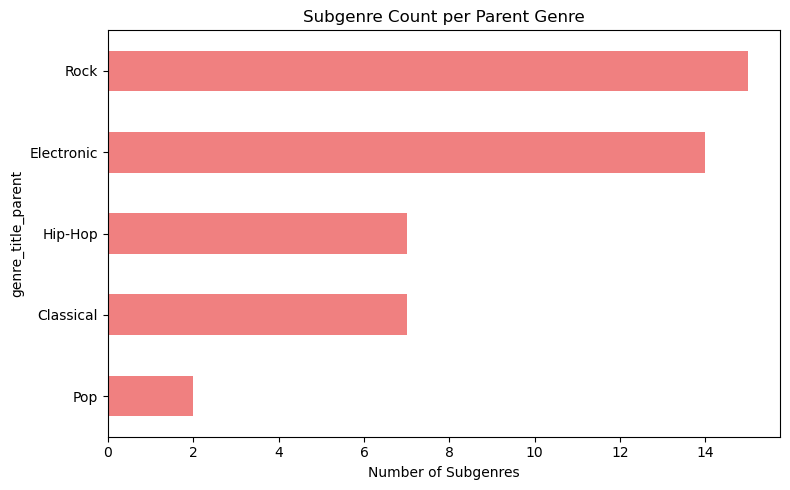

In [9]:
grouped = genres_with_subgenres[['genre_title', 'genre_title_parent']].groupby('genre_title_parent')['genre_title'].apply(list)
genre_counts = grouped.apply(len).sort_values()



plt.figure(figsize=(8, 5))
genre_counts.plot(kind='barh', color='lightcoral')
plt.xlabel('Number of Subgenres')
plt.title('Subgenre Count per Parent Genre')
plt.tight_layout()
plt.show()

In [10]:
tracks = pd.read_csv(f"{metadata_dir}/tracks.csv",
                     low_memory=False,
                    skiprows=1)

target_ready_tracks = tracks[tracks['genre_top'].isin(['Rock', 'Electronic', 'Hip-Hop', 'Pop', 'Classical'])]


print("Amount of tracks with main genre in following genres:\n'Rock', 'Electronic', 'Hip-Hop', 'Pop', 'Classical")
print(target_ready_tracks.shape[0])



Amount of tracks with main genre in following genres:
'Rock', 'Electronic', 'Hip-Hop', 'Pop', 'Classical
30668


In [11]:
amounts = target_ready_tracks['genre_top'].value_counts().to_dict()
percentages_series = (target_ready_tracks['genre_top'].value_counts() / target_ready_tracks.shape[0] * 100).to_dict()
formatted = {
    k: f"{v:.2f}%" for k, v in percentages_series.items()
}

print("Class balance")
print(formatted)

print("Labeled tracks per genre")
print(amounts)


Class balance
{'Rock': '46.24%', 'Electronic': '30.56%', 'Hip-Hop': '11.58%', 'Pop': '7.60%', 'Classical': '4.01%'}
Labeled tracks per genre
{'Rock': 14182, 'Electronic': 9372, 'Hip-Hop': 3552, 'Pop': 2332, 'Classical': 1230}


In [12]:
empty_genre_top = tracks[tracks['genre_top'].isnull() & tracks['genres'].notnull()]

print("count of tracks without main genre, but labeled with subgenres")
print(empty_genre_top[['genre_top', 'genres']].shape[0])

count of tracks without main genre, but labeled with subgenres
56976


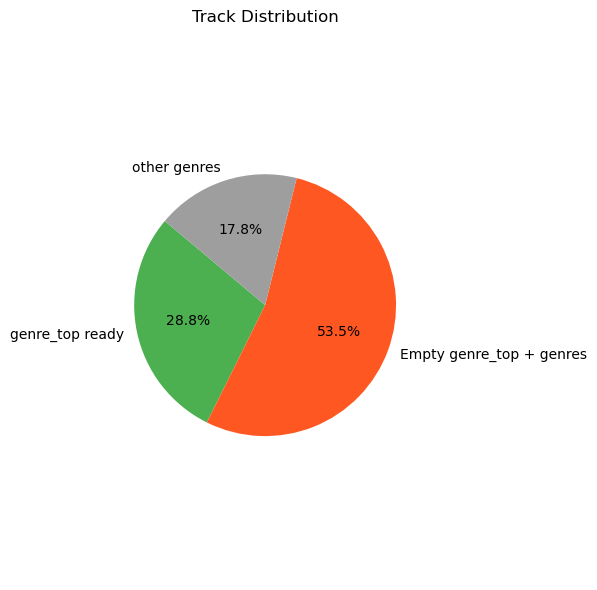

In [13]:
total = tracks.shape[0]
target_ready = target_ready_tracks.shape[0]
empty_genre_top_counts = empty_genre_top[['genre_top', 'genres']].shape[0]

labels = ['genre_top ready', 'Empty genre_top + genres', 'other genres']
values = [
    target_ready,
    empty_genre_top_counts,
    total - target_ready - empty_genre_top_counts
]

colors = ['#4CAF50', '#FF5722', '#9E9E9E']
plt.figure(figsize=(6, 6))
plt.pie(values, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
plt.title('Track Distribution')
plt.axis('equal')  # Makes the pie circular
plt.tight_layout()
plt.show()

In [14]:
genres_with_subgenres.set_index('genre_id')

value_counts = {
        'Pop': 0,
        'Rock': 0,
        'Electronic': 0,
        'Hip-Hop':0,
        'Classical':0
        }

import re
def extract_subgenres(a: str):
    vals = []
    for i in re.findall(r'\d+', a):
        vals.append(int(i))
    return vals

def get_parent_genre(raw_genres):

    """
    raw_genres  =   25
                    26
                    27
                    31, 42
                    36, 105


    """

    subgenres = extract_subgenres(raw_genres)
    
    for sub in subgenres:
        exists = genres_with_subgenres[genres_with_subgenres['genre_id'].eq(sub)]
        
        if not exists.empty:
            let = exists['genre_title_parent'].iloc[0]
            if let in value_counts.keys():
                value_counts[let] += 1
            return let
            break
            
        else:
            return None


# without top_genre
new_genres = empty_genre_top.copy()
# applies udf to extract top_genre
new_genres['genre_top'] = empty_genre_top['genres_all'].apply(get_parent_genre)

generalised_tracks_amount = new_genres['genre_top'].value_counts().values.sum()

print("new tracks from genre generalisation:")
print(new_genres['genre_top'].value_counts().to_dict())

print("summed:")
print(generalised_tracks_amount)


new tracks from genre generalisation:
{'Electronic': 4870, 'Rock': 4820, 'Hip-Hop': 1272, 'Classical': 433, 'Pop': 355}
summed:
11750


In [15]:
percentage_gained_from_generalisation = (
    new_genres[new_genres['genre_top'].notnull()]['genre_top'].value_counts() 
        / 
    empty_genre_top.shape[0] * 100
).to_dict()

formatted_gained_from_generalisation = formatted = {
    k: f"{v:.2f}%" for k, v in percentage_gained_from_generalisation.items()
}

 # procentowy zysk gatunków przez scalenie

print("Percentage of songs that were unlabeled in the entire dataset but were retrieved due to generalisation")
formatted_gained_from_generalisation

Percentage of songs that were unlabeled in the entire dataset but were retrieved due to generalisation


{'Electronic': '8.55%',
 'Rock': '8.46%',
 'Hip-Hop': '2.23%',
 'Classical': '0.76%',
 'Pop': '0.62%'}

In [16]:
df = pd.concat([target_ready_tracks, new_genres], ignore_index=True)

In [17]:
print("Total songs ready for signal extraction")
df['genre_top'].value_counts().to_dict()

Total songs ready for signal extraction


{'Rock': 19002,
 'Electronic': 14242,
 'Hip-Hop': 4824,
 'Pop': 2687,
 'Classical': 1663}

# Calculating gain in %

In [18]:
gain = (
    new_genres[new_genres['genre_top'].notnull()]['genre_top'].value_counts() 
    / 
    df['genre_top'].value_counts() * 100
 ).sort_values(ascending=False).to_dict() 

gain_percent_wise = {
    k: f"{v:.2f}%" for k, v in gain.items()
}

print("Gain explained in percents")
gain_percent_wise

Gain explained in percents


{'Electronic': '34.19%',
 'Hip-Hop': '26.37%',
 'Classical': '26.04%',
 'Rock': '25.37%',
 'Pop': '13.21%'}

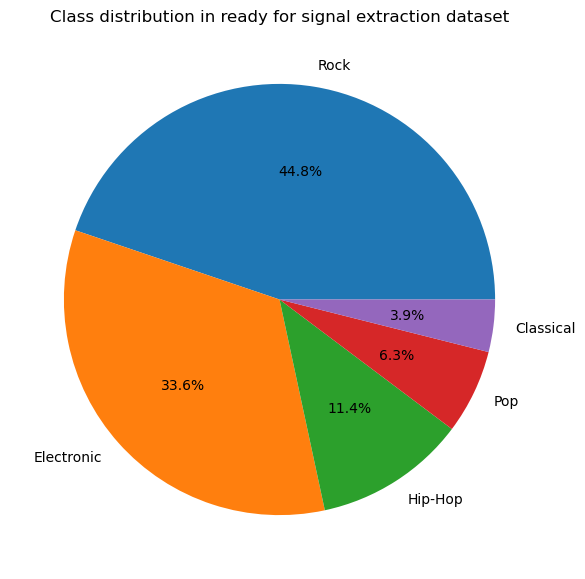

In [19]:
columns_of_interest = ["Unnamed: 0", "title.1", "name", "bit_rate", "duration", "genre_top"]

clean = df[df['genre_top'].notnull()][columns_of_interest].copy().rename(columns={"Unnamed: 0": "fma_track_id"})


class_distribution = (clean['genre_top'].value_counts() / clean.shape[0] * 100)

fig = plt.figure(figsize=(10,7))
plt.title("Class distribution in ready for signal extraction dataset")
plt.pie(x=class_distribution.values, 
        labels=class_distribution.index,
        autopct='%1.1f%%')
plt.show()

In [20]:
clean['genre_top'].value_counts()

genre_top
Rock          19002
Electronic    14242
Hip-Hop        4824
Pop            2687
Classical      1663
Name: count, dtype: int64

In [21]:
notebook_utilities.save_dataset(artifacts_folder=metadata_dir, a=clean, name="tracks_clean")

print(f"clean tracks dataframe was saved at {metadata_dir}")

clean.head()

clean tracks dataframe was saved at /mnt/e/fma_metadata


,fma_track_id,title.1,name,bit_rate,duration,genre_top
0,2,Food,AWOL,256000.0,168.0,Hip-Hop
1,3,Electric Ave,AWOL,256000.0,237.0,Hip-Hop
2,5,This World,AWOL,256000.0,206.0,Hip-Hop
3,10,Freeway,Kurt Vile,192000.0,161.0,Pop
4,134,Street Music,AWOL,256000.0,207.0,Hip-Hop
